In [1]:
from datetime import datetime

from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.imaging.imager_oskar import OskarDirtyImager, OskarDirtyImagerConfig
from karabo.imaging.imager_rascil import (
    RascilDirtyImager,
    RascilDirtyImagerConfig,
    RascilImageCleaner,
    RascilImageCleanerConfig,
)
from karabo.imaging.imager_wsclean import (
    WscleanDirtyImager,
    WscleanImageCleaner,
    WscleanImageCleanerConfig,
    create_image_custom_command,
)
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.simulator_backend import SimulatorBackend

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [2]:
SIMULATOR_BACKEND = SimulatorBackend.OSKAR

## Simulation

/home/miro/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/simulation/sky_model.py:1223: KaraboWarning: Warning: flux with value <= 0 found, setting those to np.nan to avoid logarithmic errors (only affects the colorbar)
  warn(


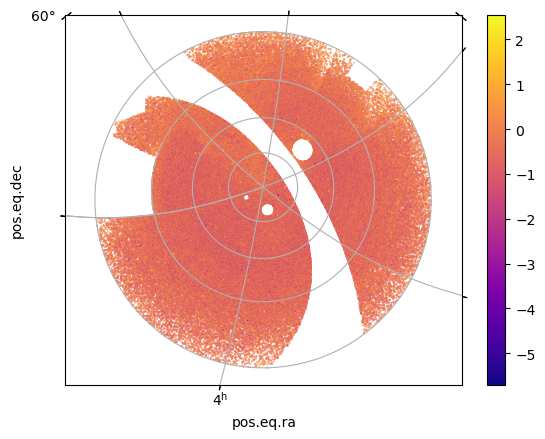

In [3]:
# Get GLEAM Survey Sky
phase_center = [250, -80]
gleam_sky = SkyModel.get_GLEAM_Sky(min_freq=72e6, max_freq=80e6)
gleam_sky.explore_sky(phase_center, s=0.1)

Then we filter the sky model based on radius.

In [4]:
sky = gleam_sky.filter_by_radius(0, 0.55, phase_center[0], phase_center[1])
sky.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 250.0  -80.0  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

Let's have a closer look with the 2d image project explore_sky() provides.

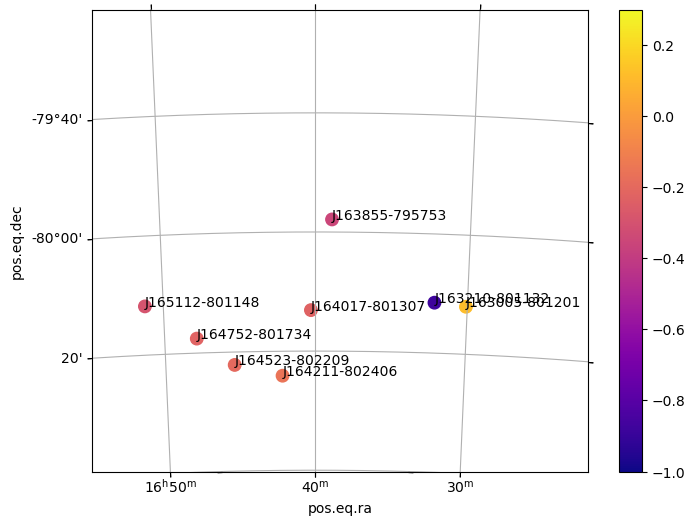

In [5]:
sky.explore_sky(
    phase_center=phase_center,
    figsize=(8, 6),
    xlim=(254, 246),  # RA-lim
    ylim=(-81, -79),  # DEC-lim
    with_labels=True,
    s=80,
    vmin=-1,
    vmax=0.3,
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

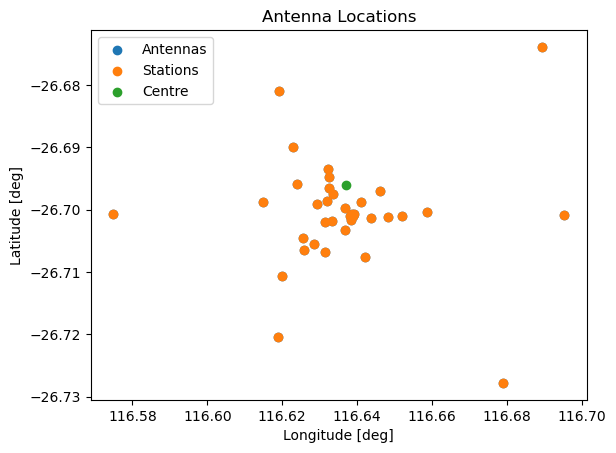

In [6]:
askap_tel = Telescope.constructor("ASKAP", backend=SIMULATOR_BACKEND)
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [7]:
from karabo.simulation.visibility import Visibility

observation_settings = Observation(
    start_frequency_hz=100e6,
    start_date_and_time=datetime(2024, 3, 15, 10, 46, 0),
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=16,
    number_of_time_steps=24,
)

# If you want, you can define where karabo should store the visibilities
# If not, karabo will decide where to store it.
vis = Visibility()
vis_path = vis.vis_path

print(f"Saving file to {vis_path}")
interferometer_sim = InterferometerSimulation(
    vis_path=vis_path, channel_bandwidth_hz=1e6
)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel, sky, observation_settings, backend=SIMULATOR_BACKEND
)

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-2yGYqtqzY0 for visibility disk-cache
Saving file to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-2yGYqtqzY0/visibility.vis
Parameter 'use_gpus' is None! Using function 'karabo.util.gpu_util.is_cuda_available()'. To overwrite, set 'use_gpus' True or False.
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6 for interferometer disk-cache.
Saved visibility to /tmp/karabo-STM-miro-HHuPfzXsfQ/visibility-2yGYqtqzY0/visibility.vis


## Imaging

There are 3 imaging algorithms delivered with Karabo:
- RASCIL (dirty) -> RASCIL (clean)
- OSKAR (dirty)
- WSClean (dirty) -> WSClean (clean)

All of them require the above generated visbilities.

In [8]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

#### RASCIL

We can create dirty images of visibilites and display them as shown below

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/Imager-Dirty-os2mv8l67q for disk-cache for dirty.fits


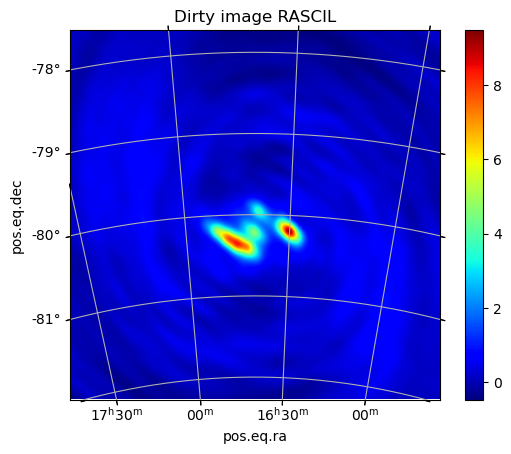

In [9]:
dirty = RascilDirtyImager(
    RascilDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibility_askap)
dirty.plot(title="Dirty image RASCIL")

Run clean algorithm and display restored image

Dashboard link: http://172.22.238.227:8787/status
LocalCluster(f2eae676, 'inproc://172.22.238.227/50044/1', workers=1, threads=16, memory=15.50 GiB)
Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/Imaging-Rascil-vdSkrbpusy for disk-cache for non-specified .fits files.


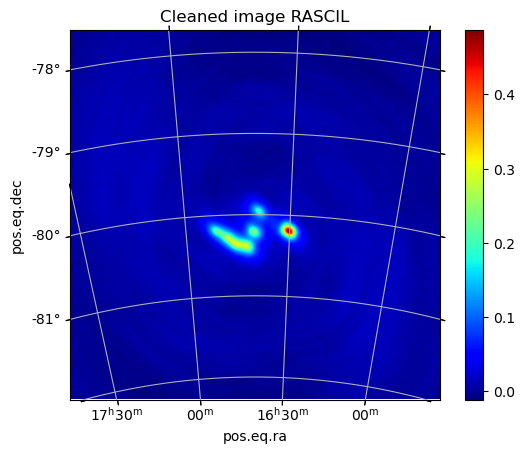

In [10]:
# Try different algorithm
# More sources
deconvolved, restored, residual = RascilImageCleaner(
    RascilImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
        ingest_vis_nchan=16,
        clean_nmajor=1,
        clean_algorithm="mmclean",
        clean_scales=[10, 30, 60],
        clean_threshold=0.12e-3,
        clean_nmoment=5,
        clean_psf_support=640,
        clean_restored_output="integrated",
        use_dask=True,
    )
).create_cleaned_image_variants(
    ms_file_path=visibility_askap.ms_file_path,
)
restored.plot(title="Cleaned image RASCIL")

#### OSKAR

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/Imager-Dirty-X1v0yYbICr for disk-cache for dirty.fits


/home/miro/miniconda3/envs/karabo/lib/python3.9/site-packages/karabo/imaging/image.py:118: UserWarning: Received 3D data for image object.
                Will assume the 3 axes correspond to
                (polarisations, pixels_x, pixels_y).
                Inserting 1 additional axis for frequencies.
  warnings.warn(


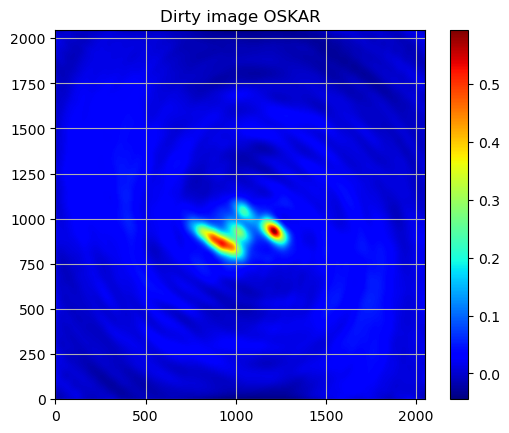

In [11]:
dirty_oskar = OskarDirtyImager(
    OskarDirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibility_askap)
dirty_oskar.plot(title="Dirty image OSKAR", wcs_enabled=False)

#### WSClean

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-zzzNnC5cm6 for Disk cache for WSClean dirty images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-dirty-zzzNnC5cm6 && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
 == Constructing image ==
Precalculating weights for uniform weighting...
Opening /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS, spw 0 with contiguous MS reader.
Mapping measurement set rows... DONE (0-15120; 15120 rows)
Detected 15.5 GB of system memory, usag

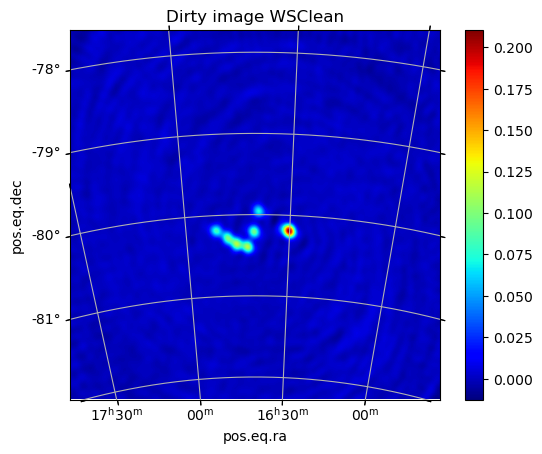

In [12]:
dirty_wsclean = WscleanDirtyImager(
    DirtyImagerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_dirty_image(visibility_askap)
dirty_wsclean.plot(title="Dirty image WSClean")

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-LcMDyVO3JH for Disk cache for WSClean cleaned images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-cleaned-LcMDyVO3JH && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -auto-threshold 3 /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%..

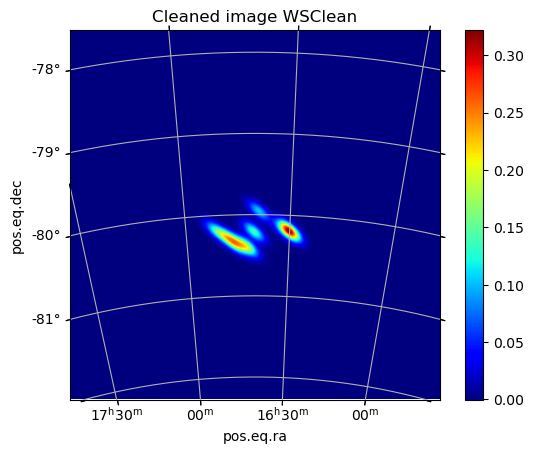

In [13]:
restored_wsclean = WscleanImageCleaner(
    WscleanImageCleanerConfig(
        imaging_npixel=imaging_npixel,
        imaging_cellsize=imaging_cellsize,
    )
).create_cleaned_image(
    ms_file_path=visibility_askap.ms_file_path,
)
restored_wsclean.plot(title="Cleaned image WSClean")

#todo customwsclean title

In [14]:
import math

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-custom-5n87kBgryM for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-custom-5n87kBgryM && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%

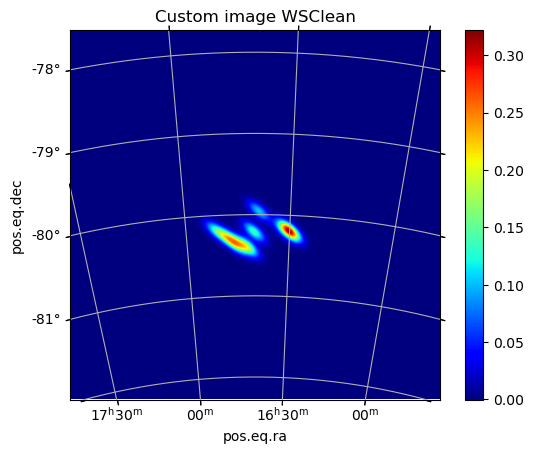

In [15]:
custom_wsclean = create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibility_askap.ms_file_path}"
)
custom_wsclean.plot(title="Custom image WSClean")

Creating /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-custom-HhiyspOozj for Disk cache for WSClean custom command images
WSClean command: [cd /tmp/karabo-STM-miro-HHuPfzXsfQ/WSClean-custom-HhiyspOozj && OPENBLAS_NUM_THREADS=1 wsclean -size 2048 2048 -scale 0.0022222222222222222deg -niter 50000 -mgain 0.8 -abs-threshold 100µJy /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS]
WSClean output:
[
WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  100-100 (16)
Reordering /tmp/karabo-STM-miro-HHuPfzXsfQ/interferometer-FU6Q7vw4K6/measurements.MS into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%

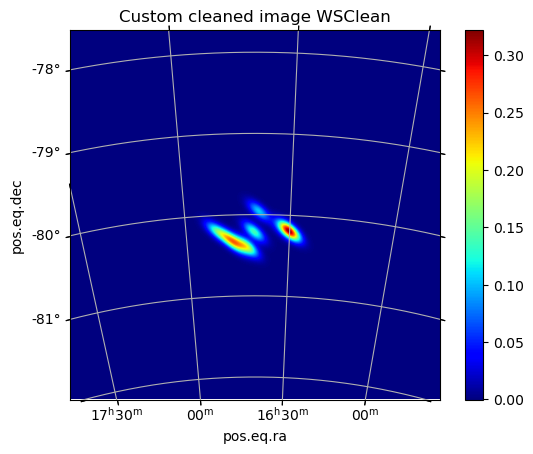

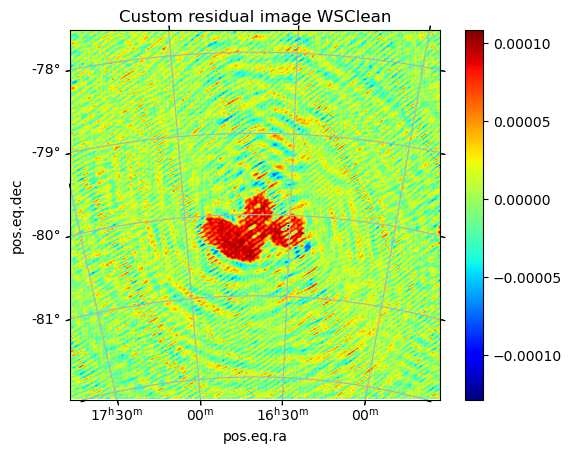

In [16]:
custom_restored_wsclean, custom_residual_wsclean = create_image_custom_command(
    "wsclean "
    f"-size {imaging_npixel} {imaging_npixel} "
    f"-scale {math.degrees(imaging_cellsize)}deg "
    "-niter 50000 "
    "-mgain 0.8 "
    "-abs-threshold 100µJy "
    f"{visibility_askap.ms_file_path}",
    ["wsclean-image.fits", "wsclean-residual.fits"],
)
custom_restored_wsclean.plot(title="Custom cleaned image WSClean")
custom_residual_wsclean.plot(title="Custom residual image WSClean")